## Data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

def prep_digits():
    """prepare digits in shape digit x h x w"""
    digits = load_digits()
    X = digits.data/255
    y = digits.target
    
    X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, random_state=42)
    
    return X_train.reshape(-1,8,8), X_test.reshape(-1,8,8), y_train, y_test

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(123)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image, target):
        return torch.from_numpy(image), torch.from_numpy(target)
                
class DataClass(Dataset):
    def __init__(self, X, y, transform=None):

        self.transform = transform
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        image = self.X[idx]
        target = self.y[idx]
        
        if self.transform:
            image, target = self.transform((image, target))
            
        return image, target

In [3]:
X_train, X_test, y_train, y_test = prep_digits()

In [4]:
params = {"batch_size": 256, 
          "h_dim": 10,
          "z_dim": 20,
          "x_dim": X_train.shape[2],
          "learning_rate": 1e-3,
          "epochs": 1000,
         }



train_set = DataClass(X_train, y_train)
test_set = DataClass(X_train, y_train)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=params["batch_size"],
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=params["batch_size"],
                                           shuffle=False)

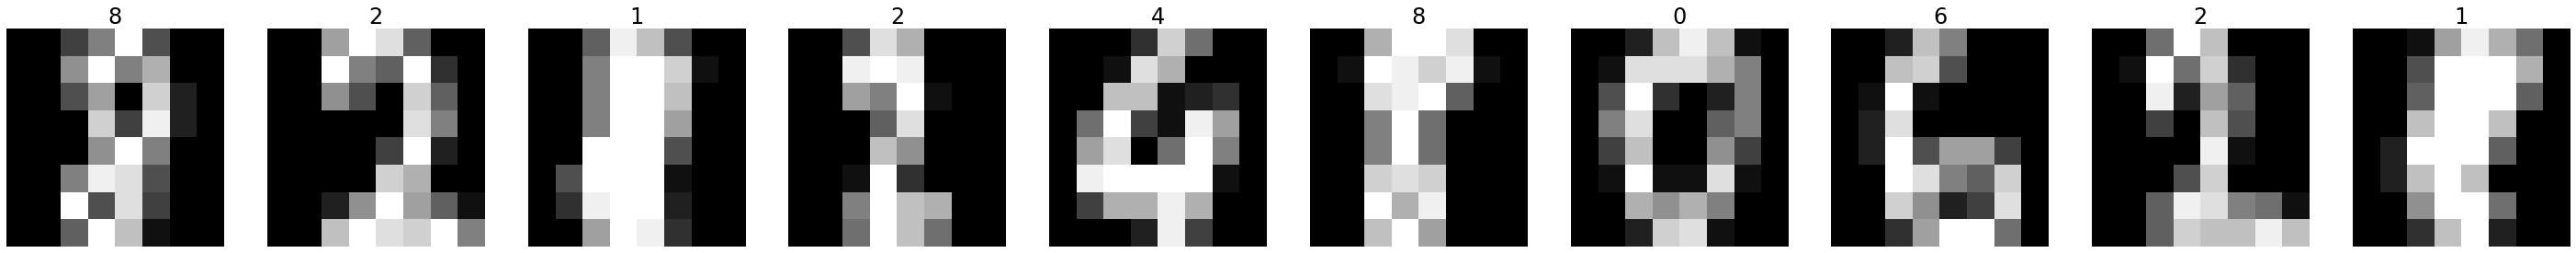

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '20'

np.random.seed(42)
n_samples = 10
f, ax = plt.subplots(1,n_samples, figsize=(5 * n_samples, 5))
for i in range(n_samples):
    n = np.random.randint(len(train_set))
    
    img, target = train_set[n]
    
    ax[i].imshow(img, cmap="gray")
    ax[i].set_title(target)
    ax[i].axis("off")

plt.show()

## model

In [6]:
from model import VRNN
from loss import loss_function
import torch.optim as optim

In [7]:
def predict_image(out, input, target, bce_loss=False):

    p_mus, p_sigmas, z_mus, z_sigmas, decoded = out
    n_samples = 10
    f, ax = plt.subplots(2, n_samples, figsize=(5 * n_samples, 10))
    for i in range(n_samples):
        
        
        
        n = np.random.randint(len(input))

        if "cuda" == device.type:

            if bce_loss:
                img = torch.sigmoid(decoded[n]).detach().cpu().numpy()
            else:
                img = decoded[n].detach().cpu().numpy()
        else:
            if bce_loss:
                img = torch.sigmoid(decoded[n]).detach().numpy()
            else:
                img = decoded[n].detach().numpy()

        ax[0,i].imshow(input[n].cpu().numpy(), cmap="gray")
        ax[1,i].imshow(img, cmap="gray")
        ax[0,i].set_title(target[n].numpy())
        ax[0,i].axis("off")
        ax[1,i].axis("off")
    
        if i == 0:
            ax[0,0].set(ylabel="True")
            ax[1,0].set(ylabel="Reconstructed")
    
    plt.show()

5.831454515457153


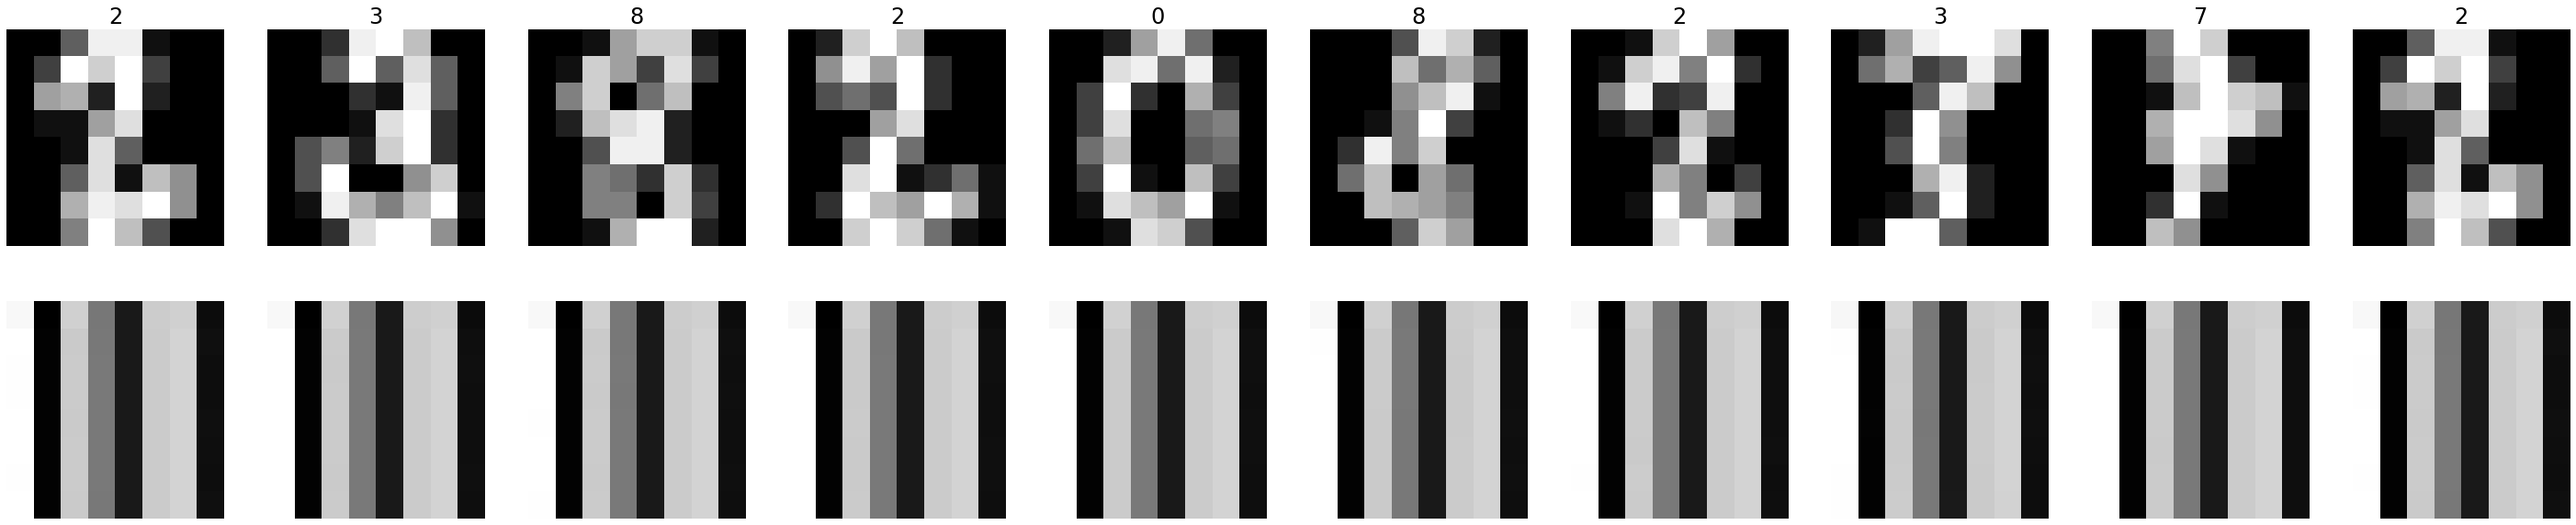

In [8]:
model = VRNN(params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
torch.cuda.manual_seed_all(12345)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

epoch_loss = 0
for i, (data, target) in enumerate(train_loader):
    img = data.to(device, dtype=torch.float)
    out = model(img)
    
    loss,_,_ = loss_function(out, img)
    
    epoch_loss += loss.item()
    
print(epoch_loss / len(train_loader))

predict_image(out, img, target)

## train

In [9]:
def evaluate(model, test_loader, params):
    model.eval()
    
    epoch_loss = 0
    rc_e_loss = 0
    kl_e_loss = 0
    
    for i, (data, target) in enumerate(test_loader):
        imgs = (data).to(device, dtype=torch.float)
        out = model(imgs)
        loss, rc_loss, kl_loss = loss_function(out, imgs)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        rc_e_loss += rc_loss.item()
        kl_e_loss += kl_loss.item()
        
    model.train()
        
    print(f"Test Loss {epoch_loss / (params['batch_size'] * len(train_loader)):.5f}")
    print(f"KL Loss {kl_e_loss / (params['batch_size'] * len(train_loader)):.5f}")
    print(f"RC Loss {rc_e_loss / (params['batch_size'] * len(train_loader)):.5f}\n")

    
def train(model, train_loader, test_loader, params, scheduler, n_warm_up=500):
    
    warm_up = 1
    kl_term = 0
    warm_up_trans = np.linspace(0,1,100)
    
    for ep in range(1, params["epochs"] + 1):
#         print("At epoch:{}".format(str(ep)))
        epoch_loss = 0
        rc_e_loss = 0
        kl_e_loss = 0
        
        if ep > n_warm_up:
            warm_up = 0
            if (ep - n_warm_up) > (len(warm_up_trans)-1):
                kl_term = 1
            else:
                kl_term = warm_up_trans[ep - n_warm_up]
            
        for i, (data, target) in enumerate(train_loader):
            imgs = (data).to(device, dtype=torch.float)
            out = model(imgs)
            
            loss, rc_loss, kl_loss = loss_function(out, imgs, warm_up=warm_up, kl_term=kl_term)
            
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            rc_e_loss += rc_loss.item()
            kl_e_loss += kl_loss.item()
            
#         if ep % config.save_every == 0:
#             torch.save(model.state_dict(), config.checkpoint_path + '/' + config.model_name + 'Epoch_' + str(ep + 1) + '.pth')
        
        if (ep % 10) == 0:
            print(f"Training Loss {epoch_loss / (params['batch_size'] * len(train_loader)):.5f}, {ep}/{params['epochs']}")
            print(f"KL Loss {kl_e_loss / (params['batch_size'] * len(train_loader)):.5f}, {ep}/{params['epochs']}")
            print(f"RC Loss {rc_e_loss / (params['batch_size'] * len(train_loader)):.5f}, {ep}/{params['epochs']}\n")
            
            evaluate(model, test_loader, params)
            
        scheduler.step()
              
    return model

In [10]:
n_warm_up = 500
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_warm_up-1, gamma=0.1)

model = train(model, train_loader, test_loader, params, scheduler, n_warm_up=n_warm_up)

Training Loss 0.00189, 10/1000
KL Loss 0.00000, 10/1000
RC Loss 0.00189, 10/1000

Test Loss 0.00144
KL Loss 0.23541
RC Loss 0.00144

Training Loss 0.00032, 20/1000
KL Loss 0.00000, 20/1000
RC Loss 0.00032, 20/1000

Test Loss 0.00032
KL Loss 0.26308
RC Loss 0.00032

Training Loss 0.00030, 30/1000
KL Loss 0.00000, 30/1000
RC Loss 0.00030, 30/1000

Test Loss 0.00030
KL Loss 0.29669
RC Loss 0.00030

Training Loss 0.00029, 40/1000
KL Loss 0.00000, 40/1000
RC Loss 0.00029, 40/1000

Test Loss 0.00029
KL Loss 0.33376
RC Loss 0.00029

Training Loss 0.00029, 50/1000
KL Loss 0.00000, 50/1000
RC Loss 0.00029, 50/1000

Test Loss 0.00029
KL Loss 0.37289
RC Loss 0.00029

Training Loss 0.00029, 60/1000
KL Loss 0.00000, 60/1000
RC Loss 0.00029, 60/1000

Test Loss 0.00029
KL Loss 0.41364
RC Loss 0.00029

Training Loss 0.00029, 70/1000
KL Loss 0.00000, 70/1000
RC Loss 0.00029, 70/1000

Test Loss 0.00029
KL Loss 0.45033
RC Loss 0.00029

Training Loss 0.00029, 80/1000
KL Loss 0.00000, 80/1000
RC Loss 0.000

Training Loss 0.00232, 620/1000
KL Loss 0.00203, 620/1000
RC Loss 0.00029, 620/1000

Test Loss 0.00029
KL Loss 0.00192
RC Loss 0.00029

Training Loss 0.00140, 630/1000
KL Loss 0.00111, 630/1000
RC Loss 0.00029, 630/1000

Test Loss 0.00029
KL Loss 0.00105
RC Loss 0.00029

Training Loss 0.00095, 640/1000
KL Loss 0.00066, 640/1000
RC Loss 0.00029, 640/1000

Test Loss 0.00029
KL Loss 0.00063
RC Loss 0.00029

Training Loss 0.00074, 650/1000
KL Loss 0.00045, 650/1000
RC Loss 0.00029, 650/1000

Test Loss 0.00029
KL Loss 0.00044
RC Loss 0.00029

Training Loss 0.00063, 660/1000
KL Loss 0.00034, 660/1000
RC Loss 0.00029, 660/1000

Test Loss 0.00029
KL Loss 0.00034
RC Loss 0.00029

Training Loss 0.00058, 670/1000
KL Loss 0.00029, 670/1000
RC Loss 0.00029, 670/1000

Test Loss 0.00029
KL Loss 0.00028
RC Loss 0.00029

Training Loss 0.00054, 680/1000
KL Loss 0.00025, 680/1000
RC Loss 0.00029, 680/1000

Test Loss 0.00029
KL Loss 0.00025
RC Loss 0.00029

Training Loss 0.00052, 690/1000
KL Loss 0.00023,

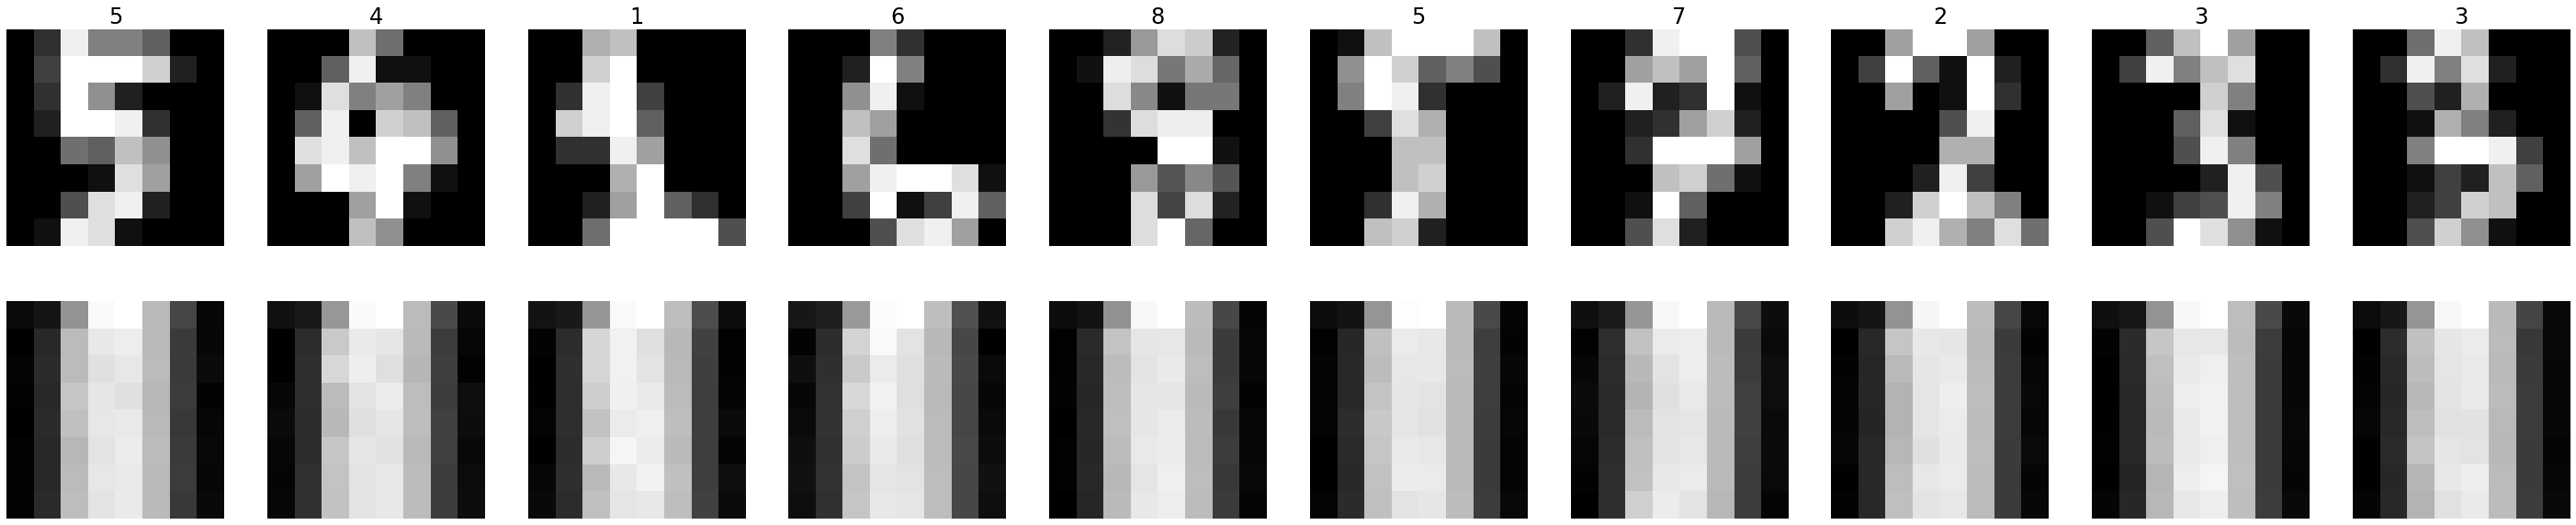

In [11]:
(data, target) = next(iter(train_loader))

imgs = (data).to(device, dtype=torch.float)
out = model(imgs)

predict_image(out, data, target)

## eval